# Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch import optim

import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
source_X, target_X, source_y_task, target_y_task, x_grid, x1_grid, x2_grid = utils.get_source_target_from_make_moons()
source_loader, target_loader, source_y_task, source_X, target_X, target_y_task = utils.get_loader(source_X, target_X, source_y_task, target_y_task)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [4]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = utils.Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [5]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [6]:
num_epochs = 1000

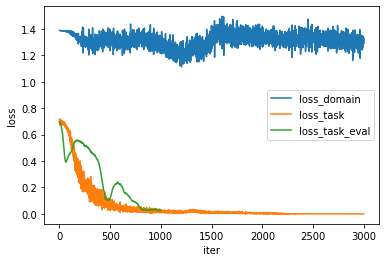

In [7]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, target_X, target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs)

# Domain Adaptation Accuracy

In [8]:
target_feature_eval = feature_extractor(target_X)
pred_y_task = task_classifier(target_feature_eval)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.9899999499320984


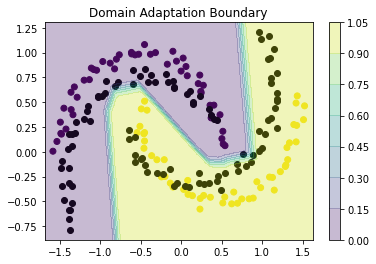

In [9]:
source_X = source_X.cpu()
target_X = target_X.cpu()

x_grid = torch.tensor(x_grid, dtype=torch.float32)
x_grid = x_grid.to(device)

x_grid_feature = feature_extractor(x_grid.T)
y_grid = task_classifier(x_grid_feature)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Domain Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# Without Adaptation

In [10]:
task_classifier = utils.Decoder(input_size=2, output_size=num_classes).to(device)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

In [11]:
for _ in range(num_epochs):
    for source_X_batch, source_Y_batch in source_loader:
        # Prep Data
        source_X_batch = source_X_batch
        source_y_task_batch = source_Y_batch[:, 0]
        
        # Forward
        pred_y_task = task_classifier(source_X_batch)
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss_task = criterion(pred_y_task, source_y_task_batch)
        
        # Backward
        task_optimizer.zero_grad()
        loss_task.backward()

        # Updata Params
        task_optimizer.step()

In [12]:
pred_y_task = task_classifier(target_X.to(device))
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Without Adaptation Accuracy:{acc}")

Without Adaptation Accuracy:0.8100000023841858


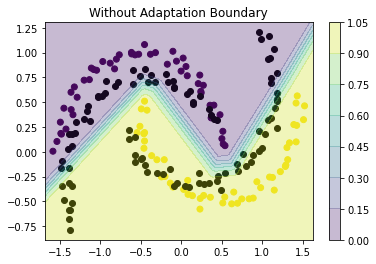

In [13]:
y_grid = task_classifier(x_grid.T)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Without Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# t-SNE Visualization for Extracted Feature

In [14]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
# TODO: Understand Argumetns for t-SNE

target_feature_eval = target_feature_eval.cpu().detach().numpy()
source_X = source_X.to(device)
source_feature = feature_extractor(source_X)
source_feature = source_feature.cpu().detach().numpy()

target_feature_tsne = tsne.fit_transform(target_feature_eval)
source_feature_tsne = tsne.fit_transform(source_feature)
# TODO: Understand t-SNE Algo 

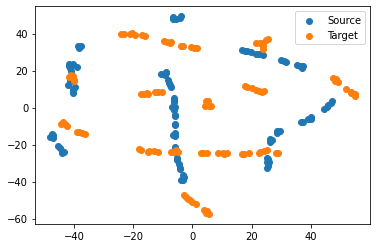

In [15]:
plt.scatter(source_feature_tsne[:, 0], source_feature_tsne[:, 1], label="Source")
plt.scatter(target_feature_tsne[:, 0], target_feature_tsne[:, 1], label="Target")
plt.legend()